# Produce a linear model regressing syllable use on size

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.plotting import figure, legend, format_plots, COLORMAPS, PLOT_CONFIG, save_factory, add_identity

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, KFold, ParameterGrid

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig2", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet"
)
df = df[keep_syllables]

size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
)
age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

# sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[df.index]

# make sure df matches sizes
df = df.loc[sizes_col.index]
age = df.index.get_level_values("age")

In [5]:
age_cut = pd.cut(df.index.get_level_values('age'), 19)

In [6]:
df['size'] = sizes_col

In [7]:
df.columns

Index([     0,      2,      4,      5,      6,      7,      9,     10,     11,
           12,     13,     14,     16,     17,     18,     23,     24,     25,
           27,     30,     32,     33,     36,     39,     41,     42,     44,
           49,     50,     52,     53,     54,     55,     59,     60,     61,
           62,     63,     64,     66,     67,     68,     69,     70,     71,
           73,     74,     76,     77,     79,     83,     84,     85,     90,
           93,     95,     97,     98, 'size'],
      dtype='object', name='syllables')

In [ ]:
x = df.iloc[:, :-1]
y = df['size']

In [64]:
pipeline = make_pipeline(
        StandardScaler(), ElasticNet(alpha=0.5, l1_ratio=1e-2, max_iter=10_000)
)

preds = cross_val_predict(
    pipeline,
    np.log(x + 1e-6),
    y,
    cv=KFold(n_splits=10, shuffle=True, random_state=0),
)
_r2 = r2_score(y, preds)

In [65]:
_r2

0.3955725444096677

webf NOT subset; don't know how to subset; dropped


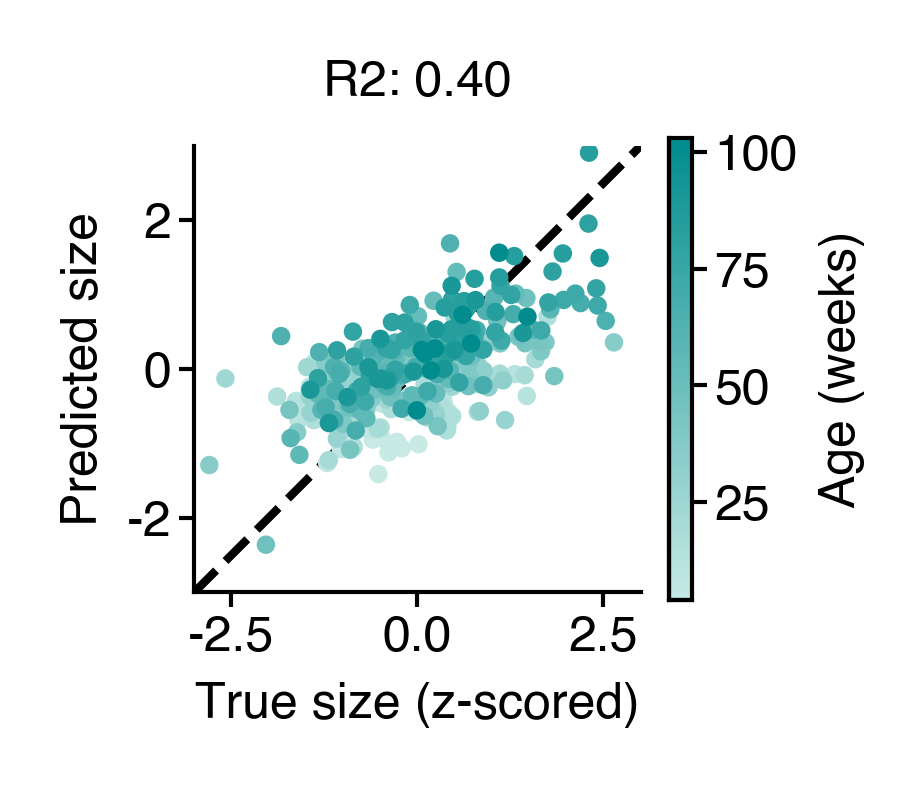

In [67]:
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.scatter(y, preds, c=age, cmap=COLORMAPS.ont_male, s=2)
add_identity(ax, ls="--", zorder=-1, c="k")
ax.set(
    xlabel="True size (z-scored)",
    ylabel="Predicted size",
    aspect="equal",
    xlim=(-3, 3),
    ylim=(-3, 3),
    title=f"R2: {_r2:0.2f}"
)
fig.colorbar(im, ax=ax, label="Age (weeks)")
sns.despine()
saver(fig, "predict-size-from-syllables");

In [57]:
pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(max_iter=10_000),
)

params = {
    'elasticnet__l1_ratio': np.linspace(0, 1, 11),
    'elasticnet__alpha': np.logspace(-3, 0, 13),
}

grid = ParameterGrid(params)

out = []
for param_set in tqdm(list(grid)):
    pipeline.set_params(**param_set)
    preds = cross_val_predict(
            pipeline.set_params(**param_set),
            x,
            y,
            cv=KFold(n_splits=6, shuffle=True, random_state=0),
            n_jobs=-1,
    ).squeeze()
    _score = r2_score(
        y, preds
    )
    param_set['score'] = _score
    _score = mean_absolute_error(
        y, preds
    )
    param_set['mae_score'] = _score
    out.append(param_set)
out = pd.DataFrame(out)

  0%|          | 0/143 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.624e+01, tolerance: 2.802e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.450e+01, tolerance: 2.704e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

<Axes: xlabel='elasticnet__l1_ratio', ylabel='elasticnet__alpha'>

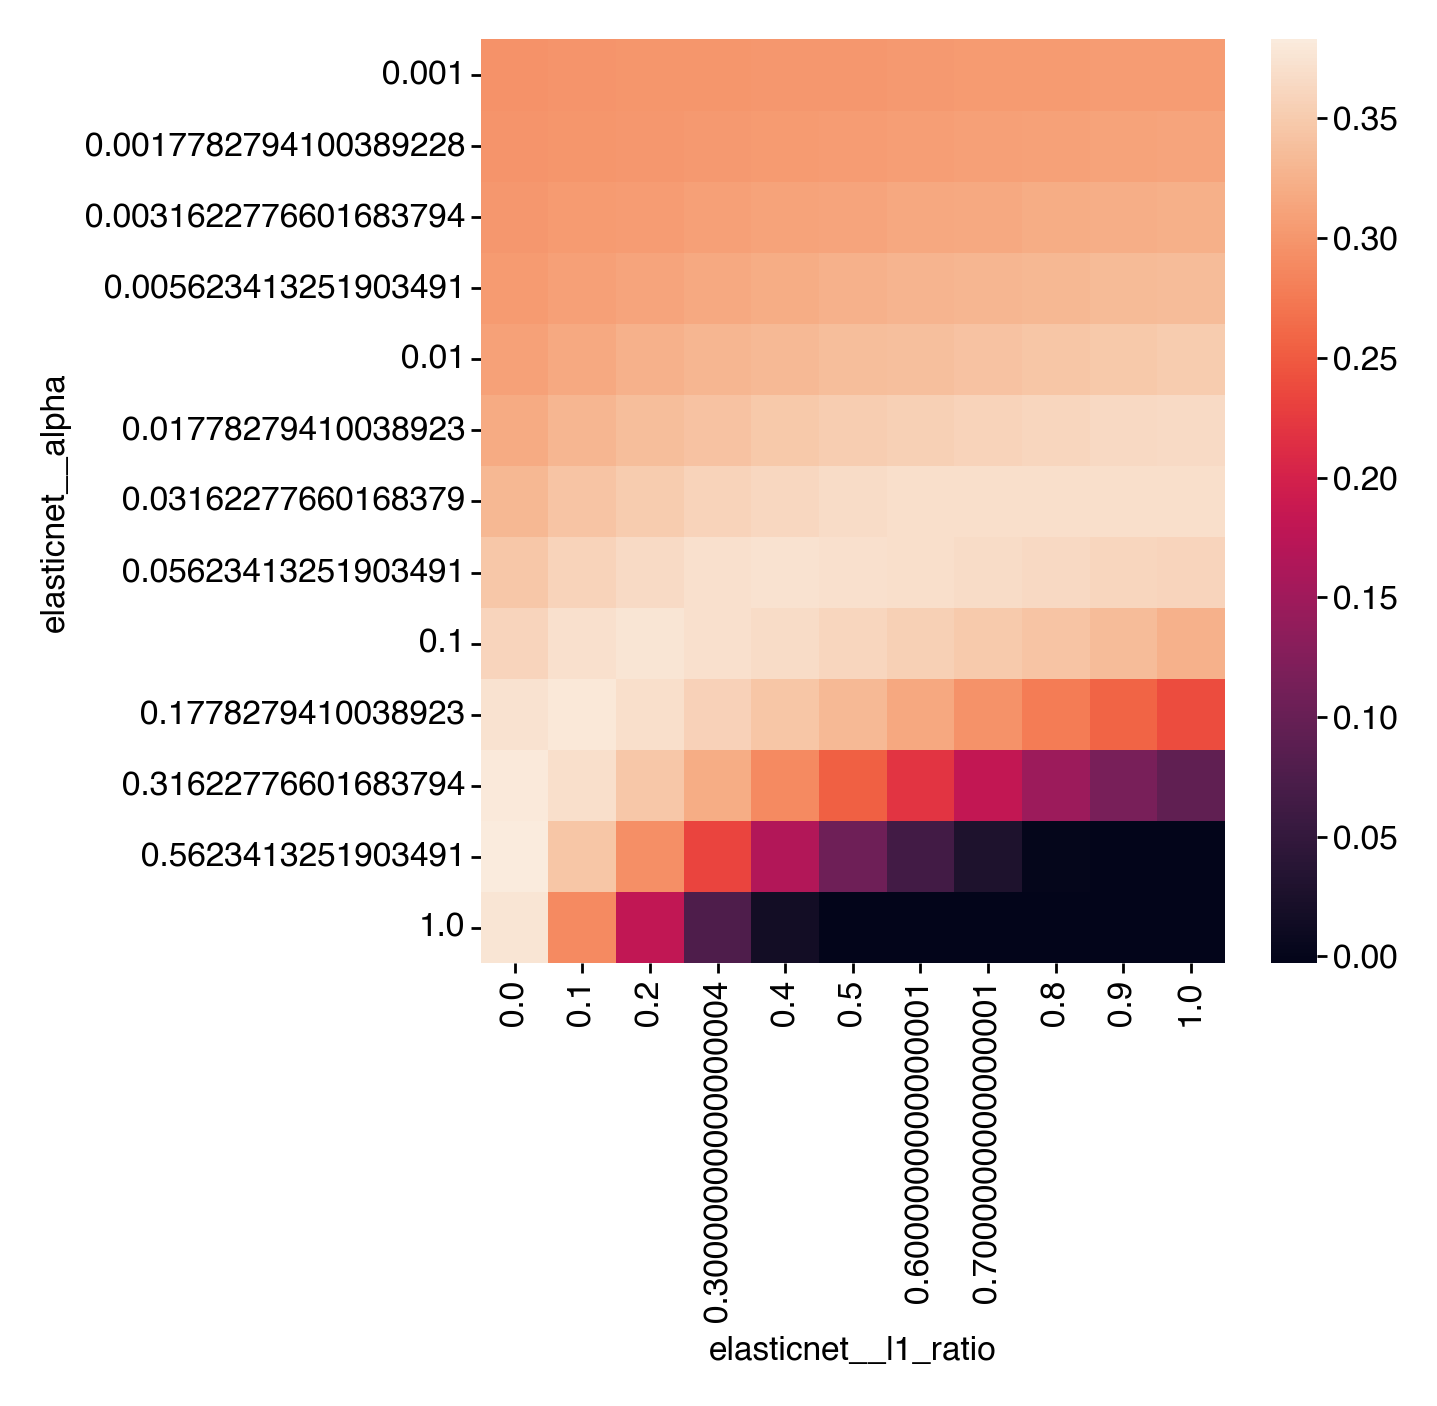

In [58]:
sns.heatmap(pd.pivot_table(out, index='elasticnet__alpha', columns='elasticnet__l1_ratio', values='score'))

<Axes: xlabel='elasticnet__l1_ratio', ylabel='elasticnet__alpha'>

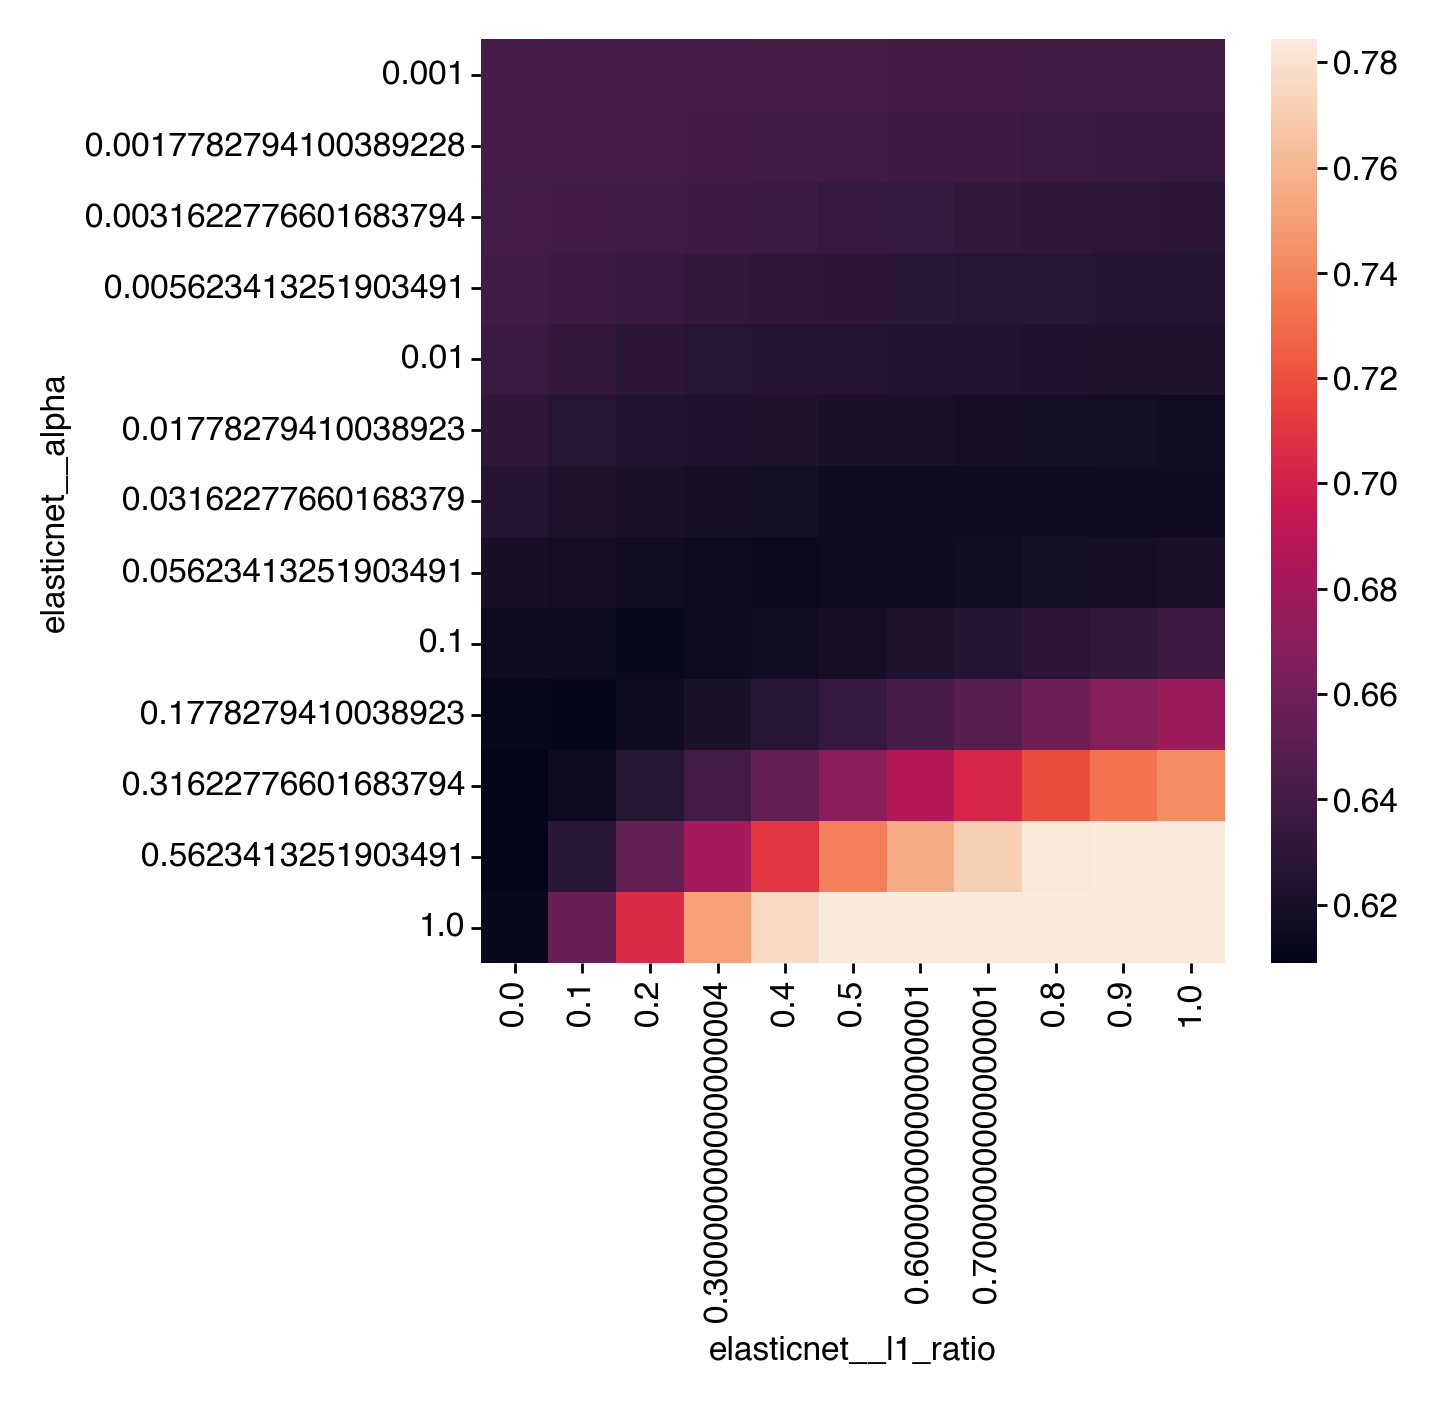

In [59]:
sns.heatmap(pd.pivot_table(out, index='elasticnet__alpha', columns='elasticnet__l1_ratio', values='mae_score'))

In [61]:
out.loc[121]

elasticnet__alpha       0.562341
elasticnet__l1_ratio    0.000000
score                   0.382980
mae_score               0.608825
Name: 121, dtype: float64

In [62]:
out.idxmin()

elasticnet__alpha         0
elasticnet__l1_ratio      0
score                   130
mae_score               121
dtype: int64

In [48]:
out.loc[121]

elasticnet__alpha       0.562341
elasticnet__l1_ratio    0.000000
score                   0.382980
Name: 121, dtype: float64